# Anomaly detection
- In contrast to statistical outliers, anomaly detection is more often concerned with local deviations than deviations from a common distribution.
- We will cover two density based methods and one tree based method.
- Density based methods are highly dependent on scaling.
    - The amount and type of scaling is problem dependent and can be considered part of the tuning.

## DBSCAN 
- Density-Based Spatial Clustering of Applications with Noise.
- No assumptions about distributions.
- Definitions:
    - 'Core point' if >= MinPts within radius $\epsilon$.
    - 'Border point' if < MinPts within radius $\epsilon$, but within radius of a 'core point'.
    - Else a 'Noise points'.
- Clustering:
    - Cluster 'core points' that lay within each others radii.
    - Assign 'border points' to their respective 'core point' clusters.
- Our main interest is in detecting 'noise points', i.e., outliers.
    - Also, small clusters may be indicative of series of outliers.

### DBSCAN in 2D
- Illustration of the concept in 2D from [Wikimedia CC-SA 3.0 by Chire](https://commons.wikimedia.org/wiki/File:DBSCAN-Illustration.svg)  
<img src="https://github.com/khliland/IND320/blob/main/D2Dbook/images/DBSCAN.png?raw=TRUE" width="300px">

### DBSCAN in 1D
- To avoid a pure vertical clustering in the charts, we need to use the observation/time dimension actively.
- The horizontal spacing between points in the chart will be an extra parameter to tune.
- More than one variable can be included in DBSCAN, but these must be matched by some form of scaling, e.g., standardisation.
- DBSCAN does not care about drift in mean values, only local density (pro and con).

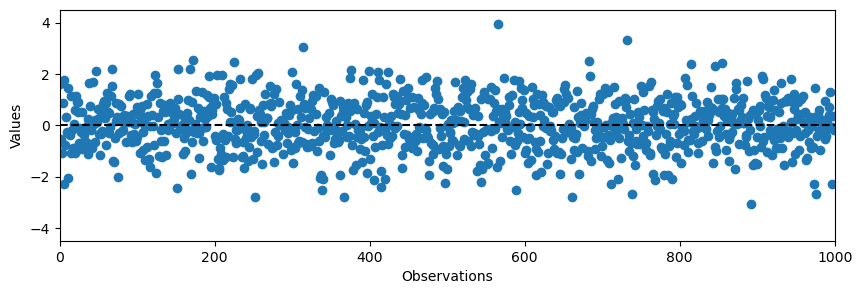

In [1]:
# Random normal data
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
N = 1000
data = np.random.normal(0, 1, N)
plt.figure(figsize=(10,3))
plt.plot(data, 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, N)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Values')
plt.xlabel('Observations')
plt.show()

In [2]:
# Import DBSCAN from sklearn
from sklearn.cluster import DBSCAN

# Reshape the data to a column vector together with an index column
step_size = 0.02
data2D = np.array([data, np.linspace(0, N*step_size, N)]).T

# Initialize and fit the DBscan model
db = DBSCAN(eps=0.5, min_samples=3, metric='euclidean')
db.fit(data2D)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
# -1 is an outlier, >=0 is a cluster

# Count number of samples in each cluster
counts = np.bincount(pred_labels+1)
counts

array([ 28, 957,   4,   3,   5,   3])

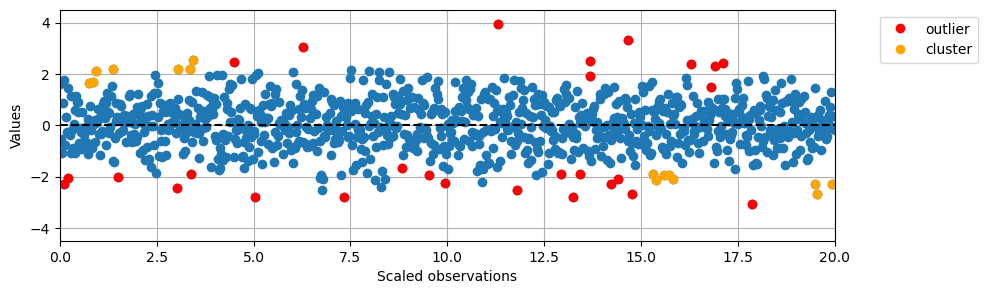

In [3]:
# Show the cluster labels
from matplotlib.lines import Line2D
plt.figure(figsize=(10,3))
plt.plot(data2D[:,1], data2D[:,0], 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, max(data2D[:,1]))
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Values')
plt.xlabel('Scaled observations')
# Plot special samples in red and orange
for i in range(len(data)):
    if pred_labels[i] == -1:
        plt.plot(data2D[i,1], data2D[i,0], 'o', color='red')
    if pred_labels[i] > 0:
        plt.plot(data2D[i,1], data2D[i,0], 'o', color='orange')
legend_elements = [Line2D([0], [0], marker='o', color='red', label='outlier', linestyle='None'),
                   Line2D([0], [0], marker='o', color='orange', label='cluster', linestyle='None')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.show()

In [4]:
# Convert the above plot to Plotly format
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data2D[:,1], y=data2D[:,0], mode='markers', marker=dict(color='blue'), name='normal'))
fig.add_trace(go.Scatter(x=data2D[:,1][pred_labels==-1], y=data2D[pred_labels==-1,0], mode='markers', marker=dict(color='red'), name='outlier'))
fig.add_trace(go.Scatter(x=data2D[:,1][pred_labels>0], y=data2D[pred_labels>0,0], mode='markers', marker=dict(color='orange'), name='cluster'))
fig.update_layout(title='DBSCAN Anomaly Detection', xaxis_title='Scaled observations', yaxis_title='Values')
fig.show()

## Exercise
- Look at the DEWP measurements in the Beijing pollution data (2000 timepoints).
- Try to tune a DBSCAN on the data.
- Does it work as advertised?

## Local Outlier Factor - LOF
- LOF is a method that tries to determine if an observation is an outlier based on the density of observations around itself compared to the density of observations around its k nearest neighbours.
- The general assumption is that $LOF_k(A) < 1$ is an outlier, but this is problem dependent.

### Definitions for LOF
For an observation A and a neighbour B:  
- k-distance(A) = distance(A, k-th nearest neighbour)
- k-neighbourhood:  
  $N_k(A) = \{\text{B} | \text{distance(A, B)} \leq \text{k-distance(A)}\}$,  
  i.e., all observations no farther away than the k-th nearest point.
- Reachability distance:  
  $RD_k(\text{A, B}) = max\{\text{k-distance(B)}, \text{distance(A, B)}\}$,  
  i.e., the maximum of observation B's k-distance and the actual distance between A and B.  
  This is maybe the least intuitive definition here as it is called a distance but is based on density and thus is unsymmetric if you change around A and B. In the figure below, $RD_3(\text{A, B}) < RD_3(\text{A, C})$ even though A is closer to B than to C.  
  <img src="https://github.com/khliland/IND320/blob/main/D2Dbook/images/Outliers_LOF_RD.png?raw=TRUE" width="300px">  

- Local reachability density:  
  $lrd_k(A) = 1 / \frac{\sum_{B \in N_k(A)} RD_k(A, B)}{|N_k(A)|}$,  
  i.e., the inverse of the average reachability distance of A from its neighbours.
- Local Outlier Factor:  
  $LOF_k(A) = \frac{\sum_{B \in N_k(A)}\frac{lrd_k(B)}{lrd_k(A)}}{|N_k(A)|} = \frac{\sum_{B \in N_k(A)}lrd_k(B)}{|N_k(A)| lrd_k(A)}$,  
  i.e., the average local reachability density of the neighbors divided by the object's own local reachability density.

### [LOF in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)
- As nearest neighbour searches can be time and memory intensive, the implementation lets the user choose between NN algorithms.
- The type of distance can be chosen.
- A "contamination" parameter is used to score samples by scikit-learn. This is the proportion of outliers, which can be set to "auto" for automatic estimation. Otherwise the proportion is used to find the threshold of outlyingness.

In [5]:
# Import LOF from sklearn
from sklearn.neighbors import LocalOutlierFactor

# Use the same data as above but replace DBSCAN with LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto') # 0.01)
pred_labels = lof.fit_predict(data2D)
counts = np.bincount(pred_labels+1)
print(counts)
print(counts[0]/sum(counts))

[ 19   0 981]
0.019


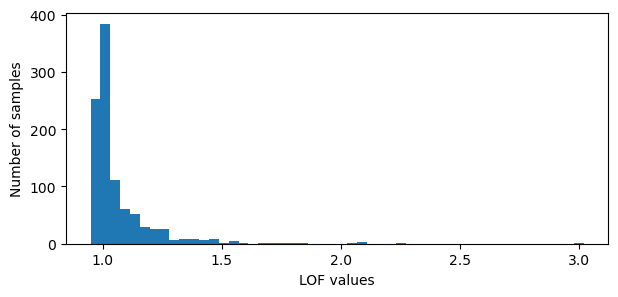

In [6]:
# Plot the LOF values
lof_pos = -lof.negative_outlier_factor_
plt.figure(figsize=(7,3))
plt.hist(lof_pos, bins=50)
plt.xlabel('LOF values')
plt.ylabel('Number of samples')
plt.show()

In [7]:
# Using default cutoff value of LOF = 1
lof_labels = 1-(lof_pos > 1)*2
np.bincount(lof_labels+1)

array([599,   0, 401])

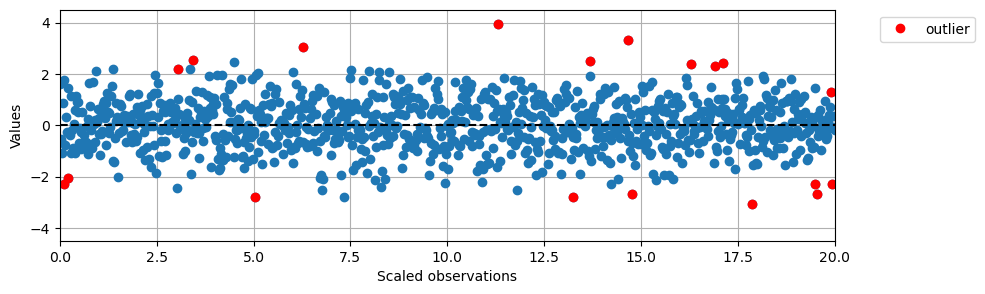

In [8]:
# Plot the results in the same way as above
preds = pred_labels.copy()
#preds = lof_labels
plt.figure(figsize=(10,3))
plt.plot(data2D[:,1], data2D[:,0], 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, max(data2D[:,1]))
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Values')
plt.xlabel('Scaled observations')
for i in range(len(data)):
    if preds[i] == -1:
        plt.plot(data2D[i,1], data2D[i,0], 'o', color='red')
legend_elements = [Line2D([0], [0], marker='o', color='red', label='outlier', linestyle='None')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.show()

## Isolation Forest
- Isolation Forests use binary trees with random splits along variables/features to isolate outlying samles.
- Basically, outlying observations are easier to split from inlying observation, thus having a shorter path through the tree before becomming a leaf node.
- In contrast to DBSCAN and LOF, no density estimation is performed.

### [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm
- An Isolation Tree (iTree) is built on a subset of the samples as follows:
    1. Randomly choose a feature.
    2. Randomly split the (remaining) data along the feature.
    3. If no more splits are possible (all observations are leafs (alone) or all samples are equal in the end nodes): terminate,  
      otherwise, repeat from 1.
- The forest is created by building many iTrees (100 is default in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)).
- Samples are deemed outliers if they on average become leaf nodes after few splits (low path-lengths in the trees).
- In scikit-learn the cut-off for being an outlier is estimated automatically, but can be changed using the "contamination" parameter.

In [9]:
# Import IsolationForest from sklearn
from sklearn.ensemble import IsolationForest

# Use the same data as above but replace DBSCAN with IsolationForest
iso = IsolationForest(n_estimators=100, contamination='auto')
pred_labels_if = iso.fit_predict(data2D)
counts = np.bincount(pred_labels_if+1)
print(counts)
print(counts[0]/sum(counts))

[274   0 726]
0.274


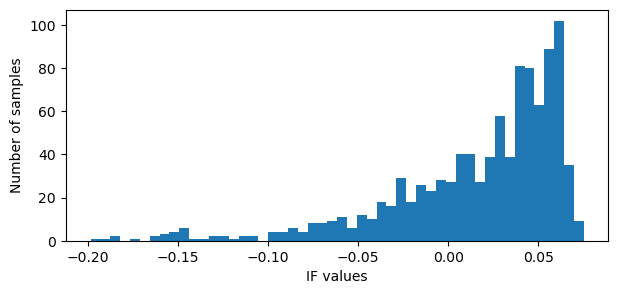

In [10]:
# Plot the IF values
if_vals = iso.decision_function(data2D)
plt.figure(figsize=(7,3))
plt.hist(if_vals, bins=50)
plt.xlabel('IF values')
plt.ylabel('Number of samples')
plt.show()

In [11]:
if_labels = 1-(if_vals < -0.15)*2
np.bincount(if_labels+1)

array([ 14,   0, 986])

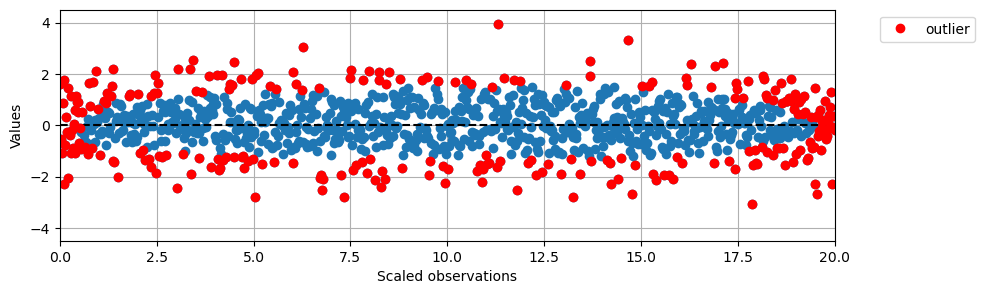

In [12]:
# Plot the results in the same way as above
preds_if = pred_labels_if.copy()
#preds_if = if_labels
plt.figure(figsize=(10,3))
plt.plot(data2D[:,1], data2D[:,0], 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, max(data2D[:,1]))
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Values')
plt.xlabel('Scaled observations')
for i in range(len(data)):
    if preds_if[i] == -1:
        plt.plot(data2D[i,1], data2D[i,0], 'o', color='red')
legend_elements = [Line2D([0], [0], marker='o', color='red', label='outlier', linestyle='None')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.show()

## Exercise
- Compare the three mentioned anomaly detection methods (DBSCAN, LOF and Isolation Forest) with regard to the samples seen as outliers.
    - Fix the parameters at _min\_samples_ = 3, _n\_neighbors_ = 20 and _n\_estimators_ = 100 and use _eps_ and _contamination_ to force 1, 2, ..., 10 outliers detected (if possible).
    - Are the three sets of 10 samples equal.
    - Do the samples appear in the same order for the different techniques?  
      Spearman correlation is one way of putting this into numbers.

## Resources
- [Wikipedia: Local Outlier Factor](https://en.wikipedia.org/wiki/Local_outlier_factor)
- [LOF in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)
- [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest)
- [scikit-learn: Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)